# Lunar Data

First we will download the data using the kaggle api

In [ ]:
!kaggle datasets download -p data romainpessia/artificial-lunar-rocky-landscape-dataset`

Then we can unzip:

In [ ]:
!unzip -d data/lunar data/artificial-lunar-rocky-landscape-dataset.zip

Now lets try to explore the data. First do our imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Don't know if i need all of these yet, but based on `lesson3-camvid.ipynb`, and `lesson3-camvid-tiramisu.ipynb`.

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import cv2

Unzip the rest

In [33]:
!chmod u+rw -R data/lunar
!unzip -d data/lunar/images data/lunar/images.zip

Archive:  data/lunar/images.zip
replace data/lunar/images/new/ground/ground2020.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [9]:
!unzip -q -d data/lunar/real_moon_images data/lunar/real_moon_images.zip

Load them into data bunches

In [47]:
art_path = Path("data/lunar/images/new/")
ground_dir = art_path/"ground"
render_dir = art_path/"render"
render_subset_dir = art_path/"render_reduced"
ground_paths = get_image_files(ground_dir)
render_paths = get_image_files(render_dir)

img_path = Path("data/lunar/real_moon_images/")
moon_paths = get_image_files(img_path)

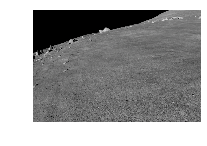

In [4]:
render_img = open_image(render_paths[2])
render_img.show()

Discover the encodings of the images.

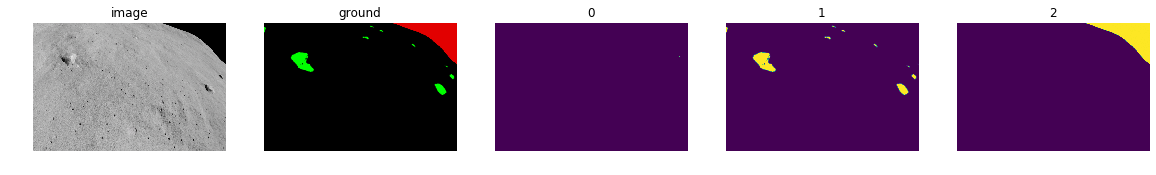

In [5]:
def get_ground_path(render_path): 
    ground_name = "ground" + render_path.name[6:]
    ground_dir = render_path.parent.parent/"ground"
    return Path(ground_dir/Path(ground_name))

render_path = render_paths[3]
render_img = open_image(render_path)
ground_path = get_ground_path(render_path)
ground_img = open_image(ground_path)

# this library encodes it as a HxWxC ndarray
ground_chans = cv2.imread(str(ground_path))
ground_chan_imgs = [Image(px=torch.from_numpy(ground_chans[:,:,i])[None]) 
                    for i in range(ground_chans.shape[2])]

_,axs = plt.subplots(1,5,figsize=(20,15))
titles = ["image", "ground"] + [str(x) for x in range(3)]
for ax,img,title in zip(axs, [render_img, ground_img] + ground_chan_imgs, titles):
    img.show(ax=ax, title=title)


- Channel 0=small (?) rocks
- 1=large rocks
- 2=sky 

Seems reasonable to overwrite each of the last, i.e. the large rocks should be prioritized over small rocks.

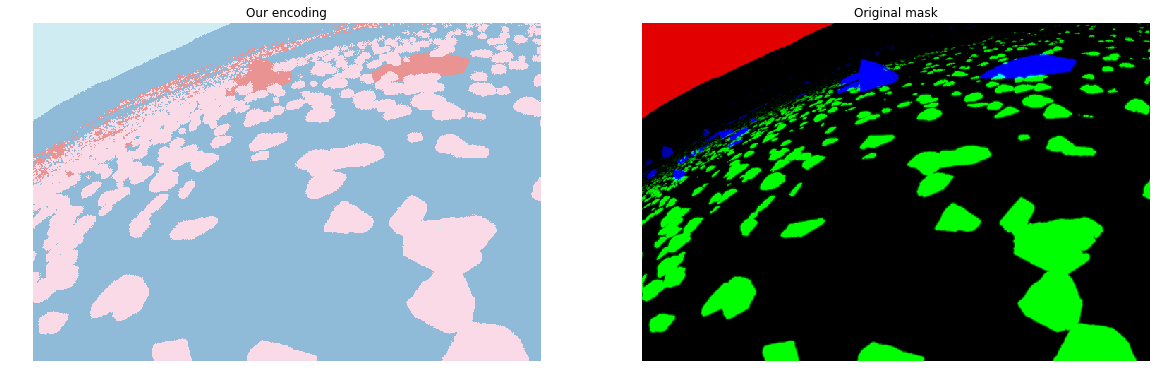

In [6]:
classes=["Void", "Small", "Large", "Sky"]

# Reencode into a segmentation. Kaggle has multiple encodings for some segmentation
# This function implicitly gives priority to the first encodings

def get_flattened_ground_array(render_path): 
    ground_name = "ground" + render_path.name[6:]
    ground_dir = render_path.parent.parent/"ground"
    ground_img = cv2.imread(str(ground_dir/Path(ground_name)))
    arr = np.zeros(ground_img.shape[:2], dtype=np.uint8)
    for i in range(ground_img.shape[2]):
        channel = (ground_img[:,:,i] > 0).astype(np.uint8) * (i+1)
        arr = np.maximum(arr, channel)
    return arr

def get_ground_mask(render_path):
    arr = get_flattened_ground_array(render_path)
    return ImageSegment(px=torch.from_numpy(arr)[None])

_,axs = plt.subplots(1,2, figsize=[20,20])
render_path = render_paths[5]
mask = get_ground_mask(render_path)
im = open_image(get_ground_path(render_path))
mask.show(ax=axs[0], title="Our encoding")
im.show(ax=axs[1], title="Original mask")

Without hacking fastai, I can only get it to work with images to input segmentations. Convert the images to pngs, hoping this will give the right segmentation data.

In [6]:
import torchvision
import PIL.Image

!mkdir data/lunar/images/new/ground_corrected

def convert_ground(render_path):
    arr = get_flattened_ground_array(render_path)
    im = PIL.Image.fromarray(arr)
    corrected_dir=render_path.parent.parent/"ground_corrected"
    corrected_path = str(corrected_dir) + "/ground"+render_path.name[6:]
    corrected_path = corrected_path.split('.')[0] + '.png'
    im.save(corrected_path)
    return corrected_path

# only need to do this once. it takes a while.
if False:
    for path in render_paths:
        convert_ground(path)

mkdir: cannot create directory ‘data/lunar/images/new/ground_corrected’: File exists


An example of a mask image:

Get the size of the mask to use (do we need to clip these from the bounding_boxes csv file??). Batch size is just what was picked in lesson3-camvid-tiramisu.

In [7]:
src_size = np.array(mask.shape[1:])
size = src_size//2
bs = 2

In [10]:
gc.collect()
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")


using bs=4, have 5190MB of GPU RAM free


Create the segmentation item list. This splits random data by percentage (default 0.2).

In [54]:
def get_corrected_ground_path(render_path):
    ground_name = ("ground" + render_path.name[6:]).split('.')[0] + '.png'
    ground_dir = render_path.parent.parent/"ground_corrected"
    return Path(ground_dir/Path(ground_name))

src = (SegmentationItemList.from_folder(render_subset_dir)
       .split_by_rand_pct()
       .label_from_func(get_corrected_ground_path, classes=classes))

Now create a data bunch **with** data augmentation.

In [55]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

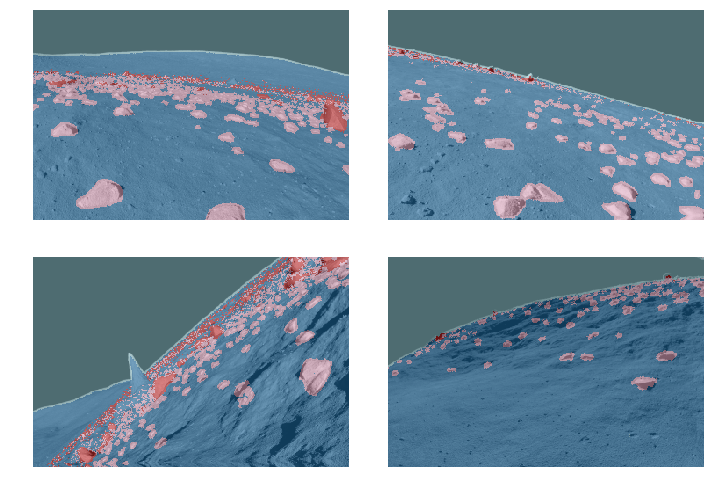

In [56]:
data.show_batch(10, figsize=(10,7))

# Model

Create a way to measure the accuracy to the encoding given by the simulated data (mean correct pixel annotations, I guess):

In [57]:
name2id = {v:k for k,v in enumerate(classes)}
void_code = name2id['Void']

def acc_sim_encoding(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()


def acc_sim_encoding_w_void(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()


Set our main parameters:

In [ ]:
wd = 1e-2 # this is lower than the default 1e-1, but should converge
metrics = [acc_sim_encoding, acc_sim_encoding_w_void]

Create a learner

In [61]:
gc.collect()
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

Find the learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


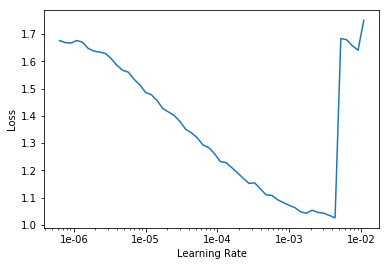

In [62]:
lr_find(learn)
learn.recorder.plot()

In [63]:
lr=2e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_sim_encoding_w_void,time
0,0.418182,0.454284,0.859150,01:07
1,0.382852,0.474304,0.841649,01:06
2,0.390134,0.353236,0.885526,01:06
3,0.380932,0.356671,0.886698,01:05
